In [1]:
# import necessary module
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
from array_response import *
import itertools 

### Parameters declaration

Declare parameters needed for channel realization

In [2]:
Ns = 1 # number of streams

Nc = 6 # number of cluster
Nray = 1 # number of rays in each cluster

Nt = 64 # number of transmit antennas
Nr = 16 # number of receive antennas

angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx

gamma = np.sqrt((Nt*Nr)/(Nc*Nray))
realization = 1000 # equivalent to number of taking sample
count = 0

eps = 0.1 # 20dB isolation
sigma = np.sqrt(8/(1+eps**2)) # according to the normalization condition of H


### Channel Realization

Realize channel H for Dual-Polarized antenna array

In [3]:
H_pol = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)
alpha_hh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_hv = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vv = np.zeros((Nc*Nray,realization),dtype=complex)

AoD = np.zeros((2,Nc*Nray),dtype=complex)
AoA = np.zeros((2,Nc*Nray),dtype=complex)

H = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
azi_rot = np.random.uniform(0,2*np.pi,realization)
ele_rot = np.random.uniform(0,np.pi/2,realization) # Why PI/2 ??
R = np.array([[np.cos(ele_rot)*np.cos(azi_rot),np.sin(ele_rot)],[-np.sin(ele_rot)*np.cos(azi_rot),np.cos(ele_rot)]]) # rotation matrix

for reali in range(realization):
    for c in range(1,Nc+1):
        AoD_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Departure _ azimuth
        AoD_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Departure _ elevation
        AoA_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Arrival_ azimuth
        AoA_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Arrival_ elevation
        AoD[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_azi_m, angle_sigma, (1,Nray))
        AoD[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_ele_m, angle_sigma, (1,Nray))
        AoA[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_azi_m, angle_sigma, (1,Nray))
        AoA[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_ele_m, angle_sigma, (1,Nray))
    for j in range(Nc*Nray):
        At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt) # UPA array response
        Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr)
        var_hh = ((sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_hv = ((eps**2)*(sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_vh = ((eps**2)*(sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[1,j])**2)).real
        var_vv = ((sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[1,j])**2)).real
        alpha_hh[j,reali] = np.random.normal(0, np.sqrt(var_hh/2)) + 1j*np.random.normal(0, np.sqrt(var_hh/2))
        alpha_hv[j,reali] = np.random.normal(0, np.sqrt(var_hv/2)) + 1j*np.random.normal(0, np.sqrt(var_hv/2))
        alpha_vh[j,reali] = np.random.normal(0, np.sqrt(var_vh/2)) + 1j*np.random.normal(0, np.sqrt(var_vh/2))
        alpha_vv[j,reali] = np.random.normal(0, np.sqrt(var_vv/2)) + 1j*np.random.normal(0, np.sqrt(var_vv/2))
        alpha = np.vstack((np.hstack((alpha_hh[j,reali],alpha_hv[j,reali])),np.hstack((alpha_vh[j,reali],alpha_vv[j,reali]))))
        H_pol[:,:,reali] = H_pol[:,:,reali] + np.kron(alpha,Ar[:,[j],reali]@At[:,[j],reali].conj().T)
    H_pol[:,:,reali] = gamma* H_pol[:,:,reali]
    H[:,:,reali] = (np.kron(R[:,:,reali],np.eye(Nr)))@H_pol[:,:,reali]
    H[:,:,reali] = np.sqrt(4/3)* H[:,:,reali]


### Check normalized condition

In [4]:
channel_fro_1 = np.zeros(realization)
for reali in range(realization):
    channel_fro_1[reali] = np.linalg.norm(H_pol[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm H pol=", np.mean(channel_fro_1**2))

4*Nt*Nr = 4096    Frobenius norm H pol= 4115.61194669


In [5]:
channel_fro_2 = np.zeros(realization)
for reali in range(realization):
    channel_fro_2[reali] = np.linalg.norm(H[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm =", np.mean(channel_fro_2**2))

4*Nt*Nr = 4096    Frobenius norm = 4084.98571114


### Joint Horizontal/Vertical Beamformer Selection

| hori_tx | hori_rx | verti_tx | verti_rx |
|:--------|--------|--------:|:---------:|


In [6]:
cluster = np.arange(Nc)
print(cluster)
c = list(itertools.combinations(cluster, 2))
num_path = (2*Nc-1)*Nc
path_combi = np.zeros((num_path,4),dtype=int)

print(path_combi.shape)
path_combi[0:Nc,:]=np.arange(Nc).reshape(Nc,1).repeat(4,axis=1)

count = 0
for i in range(int(Nc*(Nc-1)/2)):
    path_combi[Nc+4*i,:] = np.array([c[count][0],c[count][0],c[count][1],c[count][1]])
    path_combi[Nc+4*i+1,:] = np.array([c[count][1],c[count][1],c[count][0],c[count][0]])
    path_combi[Nc+4*i+2,:] = np.array([c[count][0],c[count][1],c[count][1],c[count][0]])
    path_combi[Nc+4*i+3,:] = np.array([c[count][1],c[count][0],c[count][0],c[count][1]])
    count = count+1
# print(path_combi[0:10,:])
path_gain = np.zeros((num_path,realization)) # 2 to save the position and maximum value
for reali in range(realization):
    for combi in range(num_path):
        path_gain[combi,reali] =\
        (np.abs\
         ((np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.sin(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,1])+\
         (np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.sin(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,1])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.cos(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,3])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.sin(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,3])
         ))**2


[0 1 2 3 4 5]
(66, 4)


In [7]:
#max_gain = path_gain[:,20]

In [8]:
index = np.zeros(realization,dtype=int)
for test in range(realization):
    index[test] = np.argmax(path_gain[:,test])
    #print(path_gain[index,test])

In [9]:
print(path_combi)

[[0 0 0 0]
 [1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]
 [4 4 4 4]
 [5 5 5 5]
 [0 0 1 1]
 [1 1 0 0]
 [0 1 1 0]
 [1 0 0 1]
 [0 0 2 2]
 [2 2 0 0]
 [0 2 2 0]
 [2 0 0 2]
 [0 0 3 3]
 [3 3 0 0]
 [0 3 3 0]
 [3 0 0 3]
 [0 0 4 4]
 [4 4 0 0]
 [0 4 4 0]
 [4 0 0 4]
 [0 0 5 5]
 [5 5 0 0]
 [0 5 5 0]
 [5 0 0 5]
 [1 1 2 2]
 [2 2 1 1]
 [1 2 2 1]
 [2 1 1 2]
 [1 1 3 3]
 [3 3 1 1]
 [1 3 3 1]
 [3 1 1 3]
 [1 1 4 4]
 [4 4 1 1]
 [1 4 4 1]
 [4 1 1 4]
 [1 1 5 5]
 [5 5 1 1]
 [1 5 5 1]
 [5 1 1 5]
 [2 2 3 3]
 [3 3 2 2]
 [2 3 3 2]
 [3 2 2 3]
 [2 2 4 4]
 [4 4 2 2]
 [2 4 4 2]
 [4 2 2 4]
 [2 2 5 5]
 [5 5 2 2]
 [2 5 5 2]
 [5 2 2 5]
 [3 3 4 4]
 [4 4 3 3]
 [3 4 4 3]
 [4 3 3 4]
 [3 3 5 5]
 [5 5 3 3]
 [3 5 5 3]
 [5 3 3 5]
 [4 4 5 5]
 [5 5 4 4]
 [4 5 5 4]
 [5 4 4 5]]


In [10]:
index

array([37,  1,  0, 37,  3,  4, 45,  3,  0,  3, 14, 57,  4,  0, 23,  0,  2,
       35, 58, 55,  0,  0,  0,  5,  4,  0,  2, 49,  1,  5,  5,  5,  1,  1,
        1,  0,  3,  4, 54,  2, 35,  0,  5,  0,  0,  0,  3, 46,  2,  3,  0,
       26, 62,  3,  4, 27, 50,  4,  1,  4,  1,  5, 23,  5,  2,  7,  2,  0,
        5, 63, 27,  6, 28,  3,  2,  6, 40,  1,  5,  6,  0, 34, 17,  2,  2,
        2,  0,  5,  0, 55,  1, 35,  3,  0, 10, 59, 57,  5,  4, 55,  1, 11,
        3,  2,  3,  4, 15, 47,  5,  4,  3,  2,  2,  4,  2,  3,  2,  6, 47,
        1, 18,  4,  1,  2,  0, 43,  1,  1,  1,  1, 11,  8,  4,  5,  5,  0,
        5, 34,  3,  5,  5, 53,  2, 12,  5, 34, 26, 16, 20, 27,  5,  3, 23,
        0,  2, 48, 37,  2,  0, 40,  1,  0,  4, 50, 10,  3, 51,  0,  3, 54,
       43, 19,  4, 34,  3,  4, 65, 42,  4, 26, 27,  3,  1, 50,  5,  2,  1,
       38, 26,  1,  0,  3, 27, 52,  8,  4, 41,  5, 46,  3,  1,  5,  5, 25,
       26,  0,  1,  2, 32,  0,  3,  4, 25,  2,  1, 19, 53, 27,  1,  4,  2,
        1, 22,  2,  3,  0

In [72]:
path_gain[:,1]

array([  7.83016255e+00,   1.78330275e+01,   4.75006396e+00,
         4.64985103e-01,   4.29907414e-01,   1.19802106e-01,
         4.54757515e+00,   2.37244416e+00,   7.10978010e+00,
         2.68103929e+00,   9.61466804e-01,   1.70098406e+00,
         9.70038013e-01,   3.03411509e+00,   2.48001959e-02,
         2.38432445e+00,   9.93840647e-01,   1.65988525e+00,
         1.98833563e-01,   2.06208748e+00,   5.89546818e-01,
         5.33803098e+00,   1.78596765e-01,   2.47480339e+00,
         2.43924454e-01,   2.13860034e+00,   1.05643574e+00,
         4.53870190e+00,   8.03677506e-01,   3.56629195e+00,
         1.14153987e-02,   4.48225387e+00,   1.29472378e-01,
         5.21757392e+00,   2.05340508e-01,   4.20585043e+00,
         3.26551824e-03,   8.15023196e+00,   1.64708422e-01,
         4.17491952e+00,   1.56430859e-01,   8.09457681e+00,
         5.26148747e-02,   1.01894952e+00,   6.36064527e-02,
         1.05460360e+00,   1.49365084e-01,   1.24073923e+00,
         8.97215445e-02,

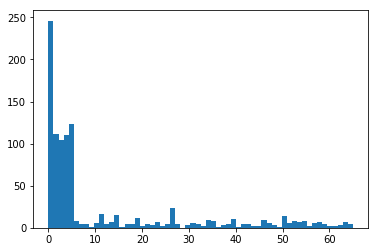

In [19]:
plt.hist(index, bins=60)
plt.show()

In [13]:
cross_index =  []
count = 7
while (count<num_path):
    cross_index.extend([count+1,count+2])
    count = count + 4
cross_index = np.array(cross_index)

In [26]:
#print(cross_index)
print(path_combi[index[1]])

[1 1 1 1]


In [18]:
cross_index_in = np.isin(index, cross_index)
# print(cross_index_in)
print(sum(cross_index_in))

85


In [17]:
diff_clus_index = np.arange(6,66)
diff_clus_index_in = np.isin(index, diff_clus_index)
# print(diff_clus_index_in)
print(sum(diff_clus_index_in))

305


### Independent Beam Steering Horizontal | Vertical 

In [82]:
steer_path = np.zeros((2,realization),dtype=int)
for reali in range(realization):
    steer_path[0,reali] = np.argmax((np.abs(alpha_hh[:,reali]))**2)
    steer_path[1,reali] = np.argmax((np.abs(alpha_vv[:,reali]))**2)
    

In [84]:
steer_path[:,2]

array([0, 4])

### Plot Spectral Efficiency

In [86]:
SNR_dB = np.arange(-35,10,5)
SNR = 10**(SNR_dB/10)
smax = SNR.shape[0]
R_cross = np.zeros([smax, realization],dtype=complex)
R_steer = np.zeros([smax, realization],dtype=complex)

for reali in range(realization):
    _chosen_combi_path = path_combi[index[reali]]
    _chosen_steer_path = steer_path[:,reali]
    
    W_cross = np.vstack((Ar[:,[_chosen_combi_path[1]],reali],Ar[:,[_chosen_combi_path[3]],reali]))
    F_cross = np.vstack((At[:,[_chosen_combi_path[0]],reali],At[:,[_chosen_combi_path[2]],reali]))
    
    W_steer = np.vstack((Ar[:,[_chosen_steer_path[0]],reali],Ar[:,[_chosen_steer_path[1]],reali]))
    F_steer = np.vstack((At[:,[_chosen_steer_path[0]],reali],At[:,[_chosen_steer_path[1]],reali]))
    
    for s in range(smax):
        R_cross[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+SNR[s]/Ns*np.linalg.pinv(W_cross)@H[:,:,reali]@F_cross@F_cross.conj().T@H[:,:,reali].conj().T@W_cross))
        R_steer[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+SNR[s]/Ns*np.linalg.pinv(W_steer)@H[:,:,reali]@F_steer@F_steer.conj().T@H[:,:,reali].conj().T@W_steer))

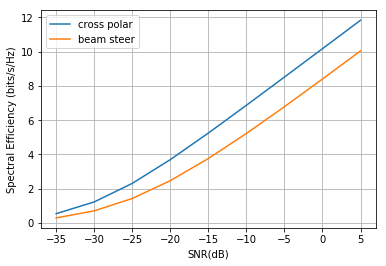

In [87]:
plt.plot(SNR_dB, (np.sum(R_cross,axis=1).real)/realization, label='cross polar')
plt.plot(SNR_dB, (np.sum(R_steer,axis=1).real)/realization, label='beam steer')

plt.legend(loc='upper left')
plt.xlabel('SNR(dB)')
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.grid()
plt.show()